### **Aluna**: Lais de Souza Ziegler
# 🛳️ Predição de sobrevivência em Naufrágio
Dataset: treino.csv

O projeto de predição de sobrevivência em naufrágios utiliza um conjunto de dados inspirado em um incidente recente no Mediterrâneo, contendo informações sobre 7.124 passageiros a bordo de um navio. As variáveis incluem identificação única do passageiro, nome, informações da cabine (deck, número e posição), procedência, destino, idade, status de VIP, modalidade de hospedagem e gastos com serviços a bordo. O objetivo é prever a probabilidade de um passageiro sobreviver ao naufrágio com base em suas características.

### 1️⃣ Leitura e exploração dos dados
---
#### Importando as bibliotecas necessárias para a análise de dados

In [49]:
# Pacotes básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pacotes do Scikit-learn para acesso a datasets, preparação, modelagem e avaliação
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Pacotes para modelos de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Pacote de balanceamento de classes desbalanceadas
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, roc_auc_score, auc



#### Carregando o conjunto de dados a partir de um arquivo CSV 
- Em seguida, imprimindo os tipos de dados de cada coluna para entender a estrutura do DataFrame
- Exibindo as primeiras cinco linhas do conjunto de dados para uma visão geral dos dados

In [50]:
df = pd.read_csv("treino.csv")
print(df.dtypes)
df.head()

IDpassageiro     object
Nome             object
Deck             object
NumeroCabine      int64
PosicaoCabine    object
Procedencia      object
Destino          object
Idade             int64
VIP                bool
AllInclusive       bool
ServicoCabine     int64
Restaurante       int64
Shopping          int64
SPA               int64
ParquedeAguas     int64
Sobrevivente       bool
dtype: object


,IDpassageiro,Nome,Deck,NumeroCabine,PosicaoCabine,Procedencia,Destino,Idade,VIP,AllInclusive,ServicoCabine,Restaurante,Shopping,SPA,ParquedeAguas,Sobrevivente
0,5647_02,Chabih Matoltuble,D,193,P,Finland,Peru,61,False,True,239,1288,3380,1158,587,True
1,0107_01,Coobix Hart,A,1202,S,Argentina,Argentina,31,True,False,466,6,11299,1598,506,True
2,4158_01,Doryn Noeley,G,107,P,Peru,China,49,True,True,1240,674,10989,806,463,True
3,1316_01,Sadrus Quelfly,G,545,S,Indonesia,Greenland,32,False,True,176,1186,8750,1438,379,True
4,9069_05,Mirfark Taketiatim,D,392,P,Indonesia,Brazil,5,False,False,90,1318,161,2853,203,True


In [51]:
# Split the names to get the last names
df['last_name'] = df['Nome'].apply(lambda x: x.split()[-1])

# Group by last name and filter for families (groups with more than one member)
families = df.groupby('last_name').filter(lambda x: len(x) > 1)

# Display the families grouped by last name
family_groups = families.groupby('last_name')['Nome'].apply(list)

print(family_groups)

last_name
Ancy                                        [Tot Ancy, Pil Ancy]
Apie                                    [Gork Apie, Frunch Apie]
Arible               [Anchab Arible, Dirk Arible, Isoton Arible]
Ausivetpul     [Marrai Ausivetpul, Betena Ausivetpul, Ionium ...
Baleful                         [Wezna Baleful, Aldibah Baleful]
                                     ...                        
Welles                             [Tonyn Welles, Carlen Welles]
Whiters                           [Berty Whiters, Ruthy Whiters]
Wiggs                               [Teremy Wiggs, Claine Wiggs]
Wolferguson               [Karia Wolferguson, Verek Wolferguson]
Yorkland       [Philda Yorkland, Rena Yorkland, Troyce Yorkland]
Name: Nome, Length: 175, dtype: object


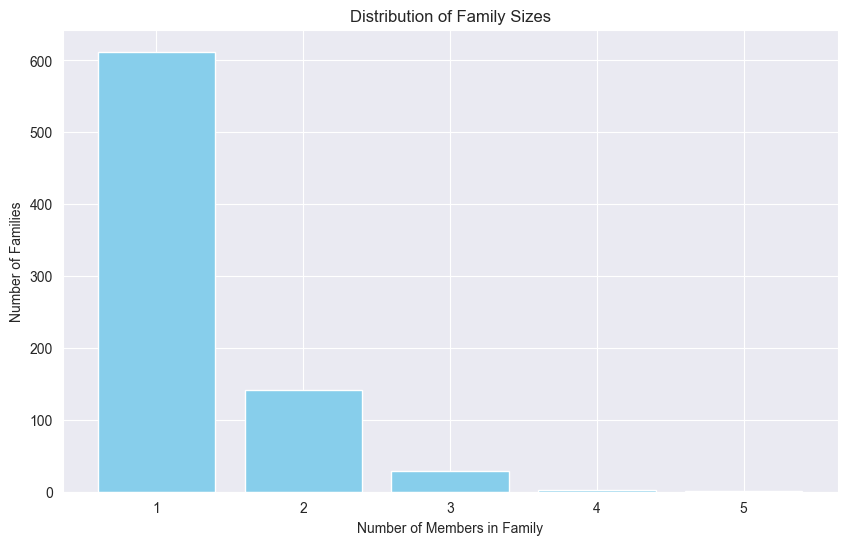

In [52]:
# Extract last names
df['last_name'] = df['Nome'].apply(lambda x: x.split()[-1])

# Group by last name and count the number of members in each family
family_sizes = df.groupby('last_name').size()

# Count how many families exist for each family size
family_size_counts = family_sizes.value_counts().sort_index()

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(family_size_counts.index, family_size_counts.values, color='skyblue')
plt.xlabel('Number of Members in Family')
plt.ylabel('Number of Families')
plt.title('Distribution of Family Sizes')
plt.xticks(family_size_counts.index)
plt.show()

In [53]:
# Group by last name and count the number of members in each family
family_sizes = df.groupby('last_name').size()

# Count singles and families
num_singles = (family_sizes == 1).sum()
num_families = (family_sizes > 1).sum()

print(f"Number of single individuals: {num_singles}")
print(f"Number of families: {num_families}")

Number of single individuals: 612
Number of families: 175


In [54]:
# Map family sizes back to the original dataframe
df['family_size'] = df['last_name'].map(family_sizes)

# Create a new column: 0 if alone, 1 if in a family
df['is_in_family'] = df['family_size'].apply(lambda x: 1 if x > 1 else 0)

# Drop the auxiliary 'last_name' and 'family_size' columns if you don’t need them
df = df.drop(columns=['last_name', 'family_size'])

print(df)

    IDpassageiro                Nome Deck  NumeroCabine PosicaoCabine  \
0        5647_02   Chabih Matoltuble    D           193             P   
1        0107_01         Coobix Hart    A          1202             S   
2        4158_01        Doryn Noeley    G           107             P   
3        1316_01      Sadrus Quelfly    G           545             S   
4        9069_05  Mirfark Taketiatim    D           392             P   
..           ...                 ...  ...           ...           ...   
995      6802_01       Eleb Disteady    G          1310             S   
996      0313_01    Briney Mckinsond    G          1165             P   
997      9094_01      Aleen Hayertez    E           520             P   
998      6594_01      Jord Schmondez    C           167             P   
999      0968_01       Tyrona Figuez    G           961             P   

                Procedencia        Destino  Idade    VIP  AllInclusive  \
0                   Finland           Peru     61

In [55]:
survival_rate = df.groupby('is_in_family')['Sobrevivente'].mean()
print("Taxa de sobrevivência:")
print(survival_rate)

Taxa de sobrevivência:
is_in_family
0    0.562092
1    0.474227
Name: Sobrevivente, dtype: float64



Correlação entre estar em família e sobreviver: -0.08576656952526966


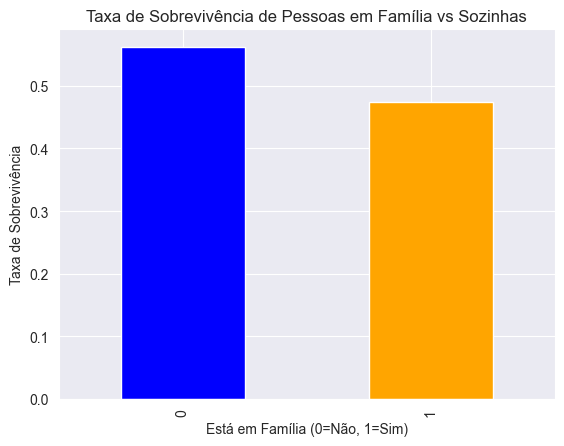

In [56]:
# Calcular a correlação entre is_in_family e Survived
correlation = df[['is_in_family', 'Sobrevivente']].corr().iloc[0, 1]
print("\nCorrelação entre estar em família e sobreviver:", correlation)

# Visualizar a diferença nas taxas de sobrevivência
import matplotlib.pyplot as plt

survival_rate.plot(kind='bar', color=['blue', 'orange'], legend=False)
plt.xlabel("Está em Família (0=Não, 1=Sim)")
plt.ylabel("Taxa de Sobrevivência")
plt.title("Taxa de Sobrevivência de Pessoas em Família vs Sozinhas")
plt.show()

#### Imprimindo a forma do DataFrame, que retorna o número de linhas e colunas e verificando se existem valores ausentes, nulos

In [57]:
print("Shape: ",df.shape)
df.isnull().any()

Shape:  (1000, 17)


IDpassageiro     False
Nome             False
Deck             False
NumeroCabine     False
PosicaoCabine    False
Procedencia      False
Destino          False
Idade            False
VIP              False
AllInclusive     False
ServicoCabine    False
Restaurante      False
Shopping         False
SPA              False
ParquedeAguas    False
Sobrevivente     False
is_in_family     False
dtype: bool

#### Rápida análise exploratória dos dados usando o método describe() para gerar estatísticas descritivas. 
- Ele fornece um resumo das principais características dos dados, ajudando a entender a distribuição e características gerais das variáveis numéricas

In [58]:
df.describe()

,NumeroCabine,Idade,ServicoCabine,Restaurante,Shopping,SPA,ParquedeAguas,is_in_family
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,688.466000,39.816000,883.92700,690.624000,7410.141000,1518.977000,356.879000,0.388000
std,404.869011,23.346203,498.44474,419.069741,4413.046425,861.974722,202.812532,0.487538
min,1.000000,0.000000,4.00000,3.000000,2.000000,0.000000,0.000000,0.000000
25%,332.750000,19.000000,473.50000,312.750000,3666.750000,797.750000,184.000000,0.000000
50%,675.000000,40.000000,878.00000,680.000000,7309.000000,1472.500000,365.500000,0.000000
75%,1049.500000,61.000000,1297.50000,1045.500000,11279.750000,2297.500000,532.000000,1.000000
max,1365.000000,79.000000,1741.00000,1425.000000,15234.000000,2955.000000,705.000000,1.000000


### 2️⃣ Pré-processamento de dados
---
#### Removendo a coluna 'IDPassageiro' e 'Nome' do DataFrame, pois elas não são relevantes para a análise ou modelagem  
- Utilizando o parâmetro 'axis=1' para indicar que a remoção é feita em colunas.

In [59]:
df = df.drop(['IDpassageiro', 'Nome'], axis = 1)

#### Transformando variáveis categóricas em quantitativas ou DUMMIES?!
- Criando colunas binárias para cada categoria
- Em seguida, convertendo todas as colunas do DataFrame para o tipo inteiro com 'astype(int)'

Esta técnica é conhecida como "One-hot Encoding". Ela é utilizada para transformar variáveis categóricas (que não possuem uma ordem numérica natural) em uma representação numérica que pode ser entendida por algoritmos de aprendizado de máquina. Isso é feito criando colunas binárias (0 ou 1) para cada possível valor da categoria.


In [60]:
# Codificação de Deck usando Label Encoding
df['Deck'] = df['Deck'].astype('category').cat.codes

# Codificação de PosicaoCabine (P = 1, S = 0)
df['PosicaoCabine'] = df['PosicaoCabine'].map({'P': 1, 'S': 0})
df.head(10)

,Deck,NumeroCabine,PosicaoCabine,Procedencia,Destino,Idade,VIP,AllInclusive,ServicoCabine,Restaurante,Shopping,SPA,ParquedeAguas,Sobrevivente,is_in_family
0,3,193,1,Finland,Peru,61,False,True,239,1288,3380,1158,587,True,0
1,0,1202,0,Argentina,Argentina,31,True,False,466,6,11299,1598,506,True,0
2,6,107,1,Peru,China,49,True,True,1240,674,10989,806,463,True,1
3,6,545,0,Indonesia,Greenland,32,False,True,176,1186,8750,1438,379,True,0
4,3,392,1,Indonesia,Brazil,5,False,False,90,1318,161,2853,203,True,0
5,1,852,1,China,Russia,72,False,True,1548,979,5356,1648,480,True,1
6,2,1150,0,Brazil,Indonesia,69,True,True,603,792,13718,2869,364,False,1
7,7,358,0,China,Portugal,5,True,False,84,873,3754,1110,357,True,1
8,4,710,0,China,Brazil,47,True,True,420,634,8517,423,487,True,1
9,2,877,0,Indonesia,United States,6,False,False,1360,16,13964,525,282,False,0


In [61]:
# Selecionar apenas colunas numéricas
numerical_df = df.select_dtypes(include=['number'])

# Calcular Q1 e Q3 e o IQR apenas nas colunas numéricas
Q1 = numerical_df.quantile(0.25)
Q3 = numerical_df.quantile(0.75)
IQR = Q3 - Q1

# Filtrar o DataFrame original, removendo os outliers
df = df[~((numerical_df < (Q1 - 1.5 * IQR)) | (numerical_df > (Q3 + 1.5 * IQR))).any(axis=1)]


In [62]:
df

,Deck,NumeroCabine,PosicaoCabine,Procedencia,Destino,Idade,VIP,AllInclusive,ServicoCabine,Restaurante,Shopping,SPA,ParquedeAguas,Sobrevivente,is_in_family
0,3,193,1,Finland,Peru,61,False,True,239,1288,3380,1158,587,True,0
1,0,1202,0,Argentina,Argentina,31,True,False,466,6,11299,1598,506,True,0
2,6,107,1,Peru,China,49,True,True,1240,674,10989,806,463,True,1
3,6,545,0,Indonesia,Greenland,32,False,True,176,1186,8750,1438,379,True,0
4,3,392,1,Indonesia,Brazil,5,False,False,90,1318,161,2853,203,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,6,1310,0,Bosnia and Herzegovina,Brazil,61,True,True,1569,106,8090,2915,680,True,0
996,6,1165,1,United States,Philippines,48,False,True,1455,70,8001,2858,361,True,0
997,4,520,1,Brazil,Ukraine,41,False,False,471,841,11890,100,437,True,0
998,2,167,1,Poland,United States,75,False,True,1072,1133,13953,1355,384,False,1


In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


# Selecionando as variáveis numéricas e categóricas
categorical_cols = ['is_in_family', 'VIP', 'AllInclusive', 'PosicaoCabine', 'Deck', 'Procedencia', 'Destino']

# Pipeline para pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)  # One-Hot Encoding para variáveis categóricas
    ])

# Passo 2: Escolha do número de clusters com o Elbow Method
X = preprocessor.fit_transform(df)

# Usando o método Elbow para escolher o K
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Plotando o Elbow Method
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Soma das Distâncias ao Quadrado (SSE)')
plt.show()

# Com base no gráfico, escolha o K ideal (onde a redução da SSE começa a diminuir)
# Digamos que K=4 seja o melhor valor (isso pode variar dependendo do gráfico)

# Passo 3: Aplicar K-Means com K = 4 (ou outro valor escolhido)
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Passo 4: Análise dos Clusters
# Para evitar o erro de agregação, vamos calcular a média apenas para as variáveis numéricas
# Para as variáveis categóricas, vamos usar a função 'first' ou 'mode' para verificar o valor mais frequente

# Em seguida, agregando as variáveis categóricas, por exemplo, usando a moda (valor mais frequente)
categorical_summary = df.groupby('Cluster')[categorical_cols].agg(lambda x: x.mode()[0])

# Combinando as duas informações
cluster_summary = pd.concat([categorical_summary], axis=1)

# Visualizar o resumo por cluster
print(cluster_summary)

# Visualização dos clusters
sns.pairplot(df, hue="Cluster", palette="Set2")
plt.show()

# Podemos também calcular o Silhouette Score para verificar a qualidade dos clusters
sil_score = silhouette_score(X, kmeans.labels_)
print(f"Silhouette Score: {sil_score}")

In [25]:
cols = ["Sobrevivente", "Idade", "NumeroCabine", "Deck", "PosicaoCabine", "is_in_family"]
train_corr = df[cols].corr()
train_corr

,Sobrevivente,Idade,NumeroCabine,Deck,PosicaoCabine,is_in_family
Sobrevivente,1.000000,0.028084,0.011796,-0.007704,-0.015130,-0.085767
Idade,0.028084,1.000000,0.004141,-0.030655,0.027304,0.040137
NumeroCabine,0.011796,0.004141,1.000000,0.015362,-0.023164,0.033892
Deck,-0.007704,-0.030655,0.015362,1.000000,-0.007834,0.047922
PosicaoCabine,-0.015130,0.027304,-0.023164,-0.007834,1.000000,0.041475
is_in_family,-0.085767,0.040137,0.033892,0.047922,0.041475,1.000000


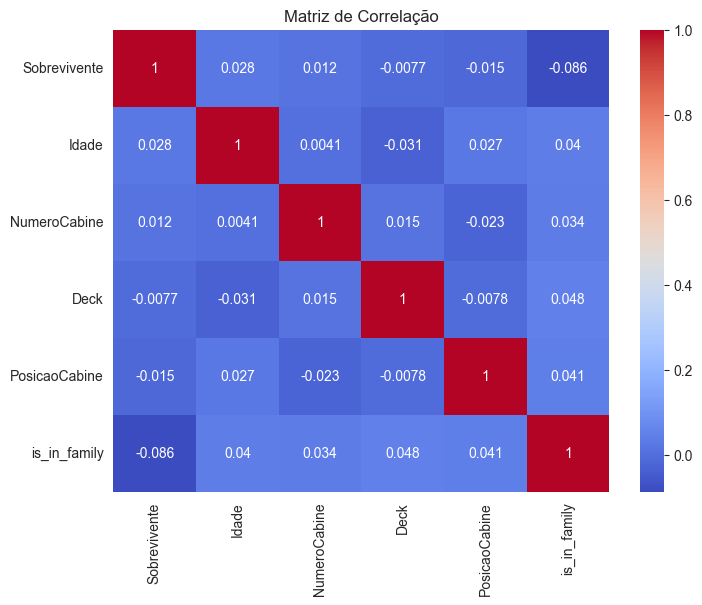

In [26]:
plt.figure(figsize=(8, 6))
sns.heatmap(train_corr, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

In [36]:
# Calculate the correlation between is_in_family and survived
correlation = df['is_in_family'].corr(df['Sobrevivente'])

print(f"Correlation between being in a family and survival rate: {correlation}")

Correlation between being in a family and survival rate: -0.08576656952526963


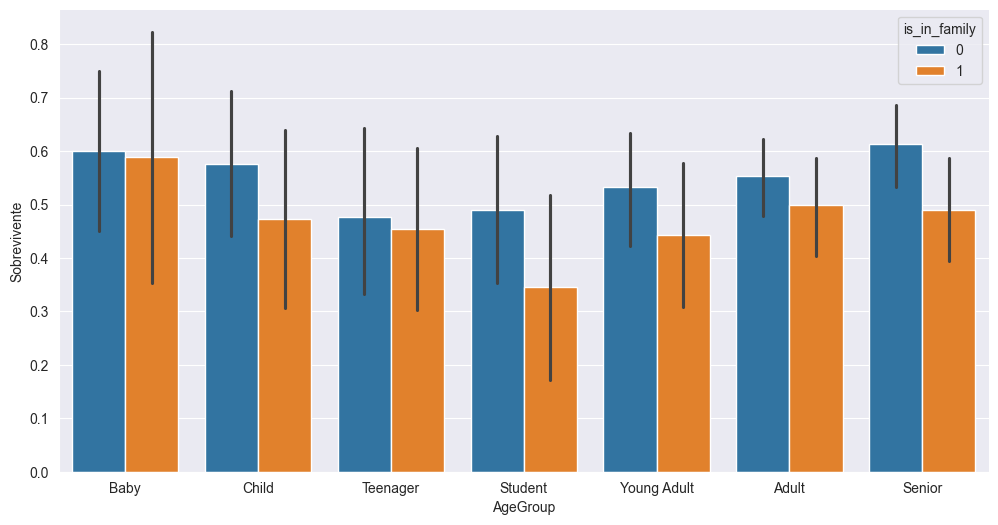

In [41]:
from matplotlib import pyplot

bins = [0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
df['AgeGroup'] = pd.cut(df["Idade"], bins, labels = labels)

df['AgeGroup'] = pd.cut(df["Idade"], bins, labels = labels)

fig, ax = pyplot.subplots(figsize=(12,6))
sns.barplot(x="AgeGroup", y="Sobrevivente", data=df,hue="is_in_family",ax=ax)

colors=["#80CEE1","#FFB6C1"]
customPalette=sns.set_palette(sns.color_palette(colors))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [27]:
le = LabelEncoder()
df['Procedencia'] = le.fit_transform(df['Procedencia'])
df['Destino'] = le.fit_transform(df['Destino'])
df

,Deck,NumeroCabine,PosicaoCabine,Procedencia,Destino,Idade,VIP,AllInclusive,ServicoCabine,Restaurante,Shopping,SPA,ParquedeAguas,Sobrevivente,is_in_family
0,3,193,1,35,93,61,False,True,239,1288,3380,1158,587,True,0
1,0,1202,0,4,4,31,True,False,466,6,11299,1598,506,True,0
2,6,107,1,87,22,49,True,True,1240,674,10989,806,463,True,1
3,6,545,0,46,43,32,False,True,176,1186,8750,1438,379,True,0
4,3,392,1,46,13,5,False,False,90,1318,161,2853,203,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,6,1310,0,13,13,61,True,True,1569,106,8090,2915,680,True,0
996,6,1165,1,116,94,48,False,True,1455,70,8001,2858,361,True,0
997,4,520,1,15,122,41,False,False,471,841,11890,100,437,True,0
998,2,167,1,89,124,75,False,True,1072,1133,13953,1355,384,False,1


In [28]:
# Dividir os dados em conjuntos de treinamento e teste
X = df.drop('Sobrevivente', axis=1)
y = df['Sobrevivente']
# X, y = SMOTE().fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
y_pred = model.predict(X_test)

In [31]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

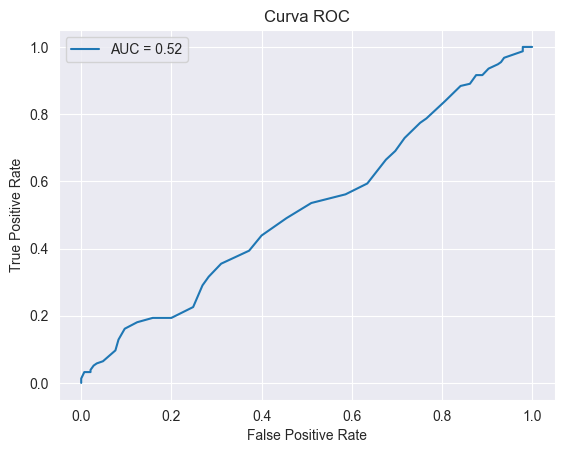

In [32]:
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [33]:
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))


Accuracy: 49.00%
Recall: 56.13%
F1 Score: 53.21%


In [34]:
#TODO: adicionar análise sobre a MELHOR decision tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Fazer previsões
y_pred_dt = dt_model.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, dt_model.predict_proba(X_test)[:, 1])

print(f'Decision Tree - Acurácia: {accuracy_dt:.2f}, Recall: {recall_dt:.2f}, F1: {f1_dt:.2f}, ROC AUC: {roc_auc_dt:.2f}')

# Plotar curva ROC
# fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_curve(dt_model, X_test, y_test)
plt.title('Curva ROC - Decision Tree')
plt.show()

# Previsões de probabilidade
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_dt)
roc_auc_dt = auc(fpr, tpr)


Decision Tree - Acurácia: 0.54, Recall: 0.60, F1: 0.57, ROC AUC: 0.54


TypeError: too many positional arguments

KNN - Acurácia: 0.57, Recall: 0.65, F1: 0.61, ROC AUC: 0.55


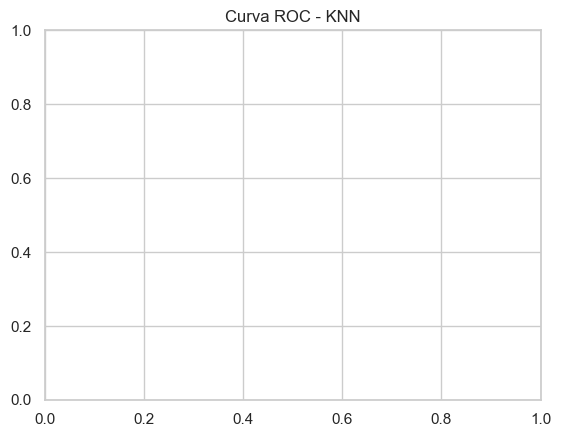

In [520]:
knn_model = KNeighborsClassifier(n_neighbors=5)  # Você pode ajustar o número de vizinhos
knn_model.fit(X_train, y_train)

# Fazer previsões
y_pred_knn = knn_model.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, knn_model.predict_proba(X_test)[:, 1])

print(f'KNN - Acurácia: {accuracy_knn:.2f}, Recall: {recall_knn:.2f}, F1: {f1_knn:.2f}, ROC AUC: {roc_auc_knn:.2f}')

# Plotar curva ROC
# roc_curve(knn_model, X_test, y_test)
plt.title('Curva ROC - KNN')
plt.show()
